In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision.io as io
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F 

In [2]:
#get a list of all the files of the dataset
casia_path=Path("./imgs")
casia_files=casia_path.glob("*/*.jpg")
casia_file_list=list(casia_files)

In [3]:
# a function that takes a path and returns the image tensor
def read_image(path):
    image_tensor = io.read_image(path)
    return image_tensor

In [4]:
# create a dataframe that contains 3 columns, subjects: refers to the id_person, file_name: refers to the images and path: that refers to the path of the images 
casia_df=pd.DataFrame(
    data={
        "subject": [str(file).split("/")[-2] for file in casia_file_list],
        "file_name": [str(file).split("/")[-1] for file in casia_file_list],
        "file_path": [str(file) for file in casia_file_list],
        # 'tensor': [load_image(str(file)) for file in tqdm(casia_file_list)]
    }
)

casia_df

,subject,file_name,file_path
0,963,79656.jpg,imgs/963/79656.jpg
1,963,79662.jpg,imgs/963/79662.jpg
2,963,79661.jpg,imgs/963/79661.jpg
3,963,79664.jpg,imgs/963/79664.jpg
4,963,79665.jpg,imgs/963/79665.jpg
...,...,...,...
490618,5178,288803.jpg,imgs/5178/288803.jpg
490619,5178,288748.jpg,imgs/5178/288748.jpg
490620,5178,288822.jpg,imgs/5178/288822.jpg
490621,5178,288788.jpg,imgs/5178/288788.jpg


In [5]:
# get images for a single subject
# casia_df[casia_df['subject']=='2']

In [6]:
# definition of a Dataset class to store the casiaDataset, the objective is to use a DataLoader later to train the model
class CasiaDataset(Dataset):
    def __init__(self, file_names, file_paths, subjects):
        self.file_names=file_names
        self.file_paths=file_paths
        self.subjects=subjects
    def __len__(self):
        return len(self.file_names)
    def __getitem__(self,idx): #this function returns a pair of images

        image_tensor_1=read_image(self.file_paths[idx]) #we read the first image
        subject_1=self.subjects[idx] #we get the subject of the image (the person)

        if np.random.binomial(n=1,p=0.5) == 0: #with a probability of 0.5, we take another image of the same person
            same_subject_indices=self.subjects[self.subjects==subject_1].index
            image_2_idx=same_subject_indices[np.random.randint(0,len(same_subject_indices))]
        else:
            diff_subject_indices=self.subjects[self.subjects!=subject_1].index #with a probability of 0.5, we take another image of a different person
            image_2_idx=diff_subject_indices[np.random.randint(0,len(diff_subject_indices))]

        image_tensor_2=read_image(self.file_paths[image_2_idx])

        label=subject_1==self.subjects[image_2_idx]

        return image_tensor_1, image_tensor_2, label
    
    #with this function, we ensure that the distribution of my dataset is the following: 50% of pair images are positive (same person) and 50% of pair images are negative

In [7]:
#create the object dataset
casia_dataset=CasiaDataset(casia_df['file_name'],casia_df['file_path'],casia_df['subject'])

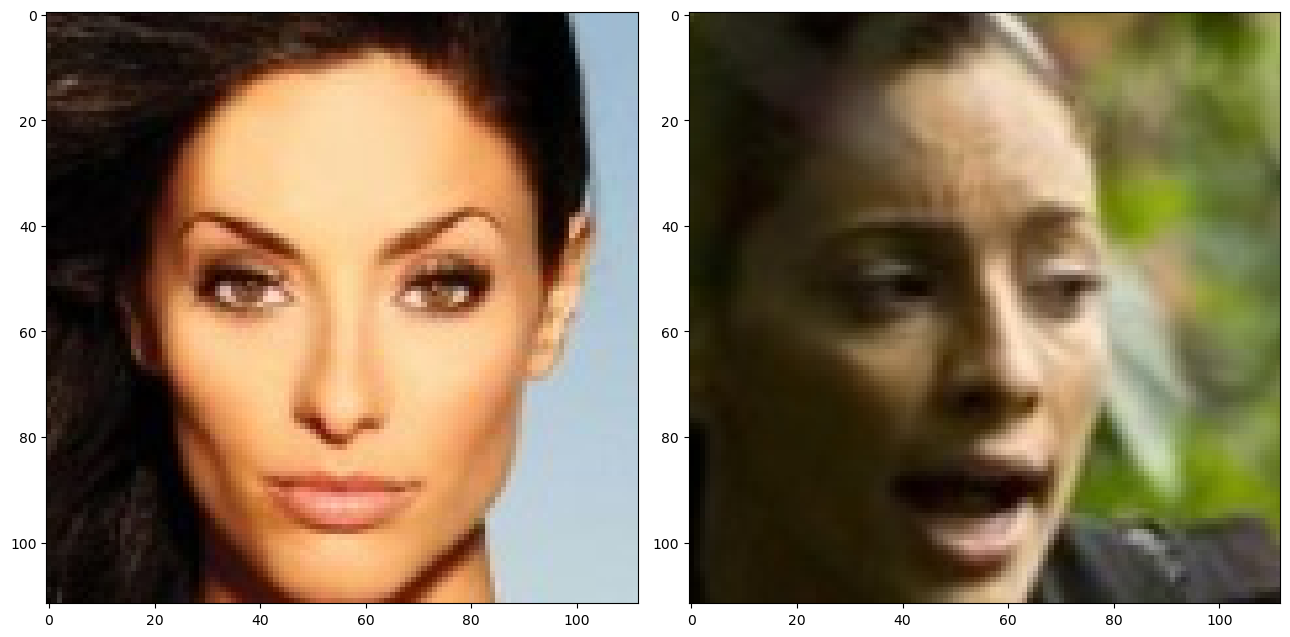

True


In [8]:
#display a couple of images
image_tensor_1, image_tensor_2, label = casia_dataset[1000]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 13))
axes = axes.flatten()
axes[0].imshow(image_tensor_1.numpy().transpose(1,2,0))
axes[1].imshow(image_tensor_2.numpy().transpose(1,2,0))
plt.tight_layout()
plt.show()
print(label)

In [9]:
#create a Dataloader: the objective of my dataloader is to permit the creation of many batches during the training of the model later
casia_dataloader = DataLoader(casia_dataset, batch_size=64, shuffle=True)

In [10]:
batch=next(iter(casia_dataloader))

In [11]:
len(batch[0])

64

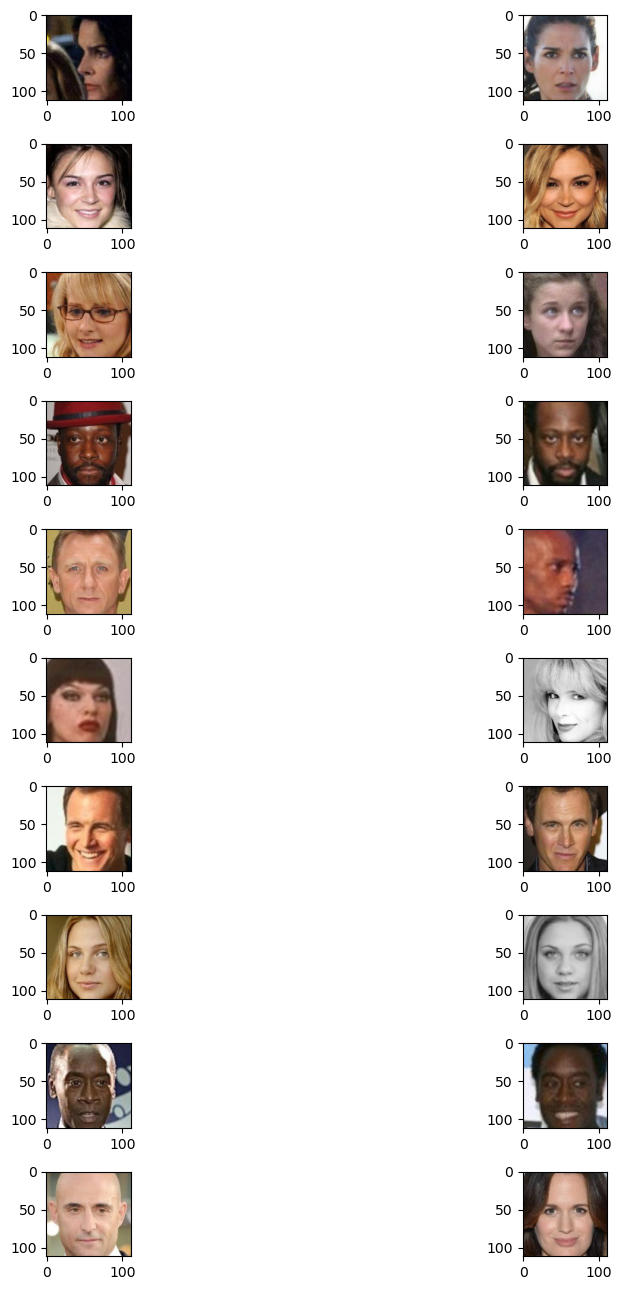

In [12]:
#display a batch of a couple of images
img_limit=10
for batch in casia_dataloader:
    fig, axes = plt.subplots(nrows=img_limit, ncols=2, figsize=(13, 13))
    for image_idx,image_tensor_1 in enumerate(batch[0][:img_limit]):
        axes[image_idx,0].imshow(image_tensor_1.numpy().transpose(1,2,0))

    for image_idx,image_tensor_2 in enumerate(batch[1][:img_limit]):
        axes[image_idx,1].imshow(image_tensor_2.numpy().transpose(1,2,0))

    plt.tight_layout()
    plt.show()
    break

In [13]:
class FV_CNN_Model(nn.Module):
    def __init__(self):
        super(FV_CNN_Model, self).__init__()
        #the model contains 6 CNN and an MLP, to feed the two images of one pair, we use the CNN as a siamese network

        self.conv1=nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(11,11), stride=1, padding=5)
        self.pool1=nn.MaxPool2d(kernel_size=(12,12), stride=1)

        self.conv2=nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(11,11), stride=1, padding=5)
        self.pool2=nn.MaxPool2d(kernel_size=(21,21), stride=1)

        self.conv3=nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(11,11), stride=1, padding=5)
        self.pool3=nn.MaxPool2d(kernel_size=(21,21), stride=1)

        self.conv4=nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(11,11), stride=1, padding=5)
        self.pool4=nn.MaxPool2d(kernel_size=(21,21), stride=1)

        self.conv5=nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(11,11), stride=1, padding=5)
        self.pool5=nn.MaxPool2d(kernel_size=(21,21), stride=1)

        self.conv6=nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(11,11), stride=1, padding=5)
        self.pool6=nn.MaxPool2d(kernel_size=(21,21), stride=1)

        self.linear=nn.Linear(in_features=80, out_features=1, bias=True)
        self.sigmoid=nn.Sigmoid()
        self.relu=nn.ReLU()

        self.conv_network=nn.Sequential(
            self.conv1,
            self.relu,
            self.pool1,

            self.conv2,
            self.relu,
            self.pool2,

            self.conv3,
            self.relu,
            self.pool3,

            self.conv4,
            self.relu,
            self.pool4,

            self.conv5,
            self.relu,
            self.pool5,

            self.conv6,
            self.relu,
            self.pool6
        )

    def forward(self, x_1, x_2):
        embed_1=self.conv_network(x_1).squeeze((-1,-2))
        embed_2=self.conv_network(x_2).squeeze((-1,-2))
        #the predection with MLP
        embed = torch.cat((embed_1,embed_2))

        logits=self.linear(embed)
        probs=self.sigmoid(logits)

        return probs


In [14]:
fv_cnn_model=FV_CNN_Model()

In [15]:
fv_cnn_model(image_tensor_1.float(),image_tensor_2.float())

tensor([0.6659], grad_fn=<SigmoidBackward0>)